<a href="https://colab.research.google.com/github/patel-zeel/Nonstat-exps/blob/main/GP_Extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!git clone https://github.com/jmetzen/gp_extras.git
!cd gp_extras;python setup.py install
!pip -qq install GPy

fatal: destination path 'gp_extras' already exists and is not an empty directory.
running install
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_py
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.6/dist-packages/gp_extras-0.0.0.egg-info
Writing /usr/local/lib/python3.6/dist-packages/gp_extras-0.0.0.egg-info
running install_clib
customize UnixCCompiler


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from gp_extras.kernels import ManifoldKernel, LocalLengthScalesKernel, HeteroscedasticKernel
from GPy.models import GPRegression
from GPy.kern import Matern32 as GPyMatern, RBF as GPyRBF
from sklearn.preprocessing import StandardScaler

# trial
m = GPRegression(np.ones((2,1)), np.ones((2,1)),GPyMatern(1))
m.preferred_optimizer

'lbfgsb'

# Local lengthscale kernel

Tries to learn lengthscale locally for few points without affecting overall fit

## Step function

shape of train_X= (20, 1) shape of train_y= (20, 1)


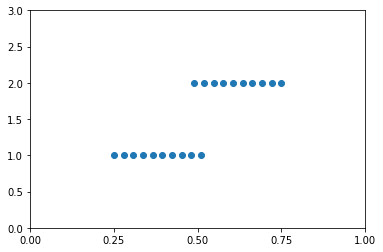

In [103]:
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

## Defining stationary and non-stationary GPs (gp, GPygp and nonstat_gp)

In [104]:
# sklearn
kernel = C() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# GPy
class GPyGPR:
  def __init__(self, input_dim, kern):
    if kern=='rbf':
      self.GPykernel = GPyRBF(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    if kern=='m32':
      self.GPykernel = GPyMatern(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    self.kernel = self.GPykernel
  def fit(self, X, y):
    self.GP = GPRegression(X, y, self.GPykernel, noise_var=10**-10)
    self.GP.optimize_restarts(10, verbose=0)
    self.kernel_ = self.GP.kern
  
  def predict(self, X, return_cov):
    y, var = self.GP.predict(X, full_cov=return_cov)
    return y, var

GPygp = GPyGPR(1, 'rbf')

# Non stationary kernel
from scipy.optimize import differential_evolution
scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
def de_optimizer(obj_func, initial_theta, bounds):
    res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                 bounds, maxiter=20, disp=False, polish=False)
    return res.x, obj_func(res.x, eval_gradient=False)
nonstat_kernel = C() * LocalLengthScalesKernel.construct(train_XX, l_L=0.1, l_U=2.0, l_samples=5)
nonstat_gp = GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

print("sklearn kernel=\n", kernel,sep='',end='\n\n')
print("GPy kernel=\n", GPygp.GPykernel,sep='',end='\n\n')
print("LLS kernel=\n", nonstat_kernel,sep='')

sklearn kernel=
1**2 * RBF(length_scale=1)

GPy kernel=
  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

LLS kernel=
1**2 * LocalLengthScalesKernel(theta_gp=[0.1], theta_l=[0.1], length_scales=[1. 1. 1. 1. 1.])


## Testing on step function

RBF 1.55**2 * RBF(length_scale=0.0975)
RBF GPy   rbf.         |               value  |  constraints  |  priors
  variance     |  1.7303585887944406  |      +ve      |        
  lengthscale  |  1.7354044892675953  |      +ve      |        
LLS RBF 2.13**2 * LocalLengthScalesKernel(theta_gp=[0.03338469], theta_l=[0.12235441], length_scales=[1.01972819 0.95924977 0.10656024 0.98485707 1.04078452])


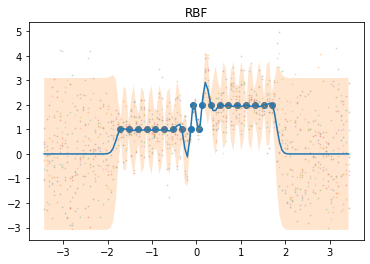

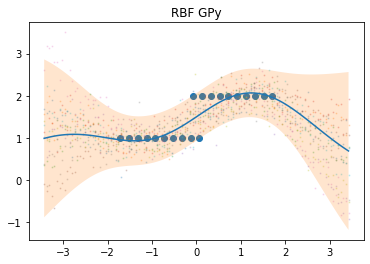

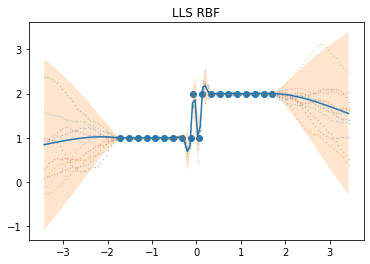

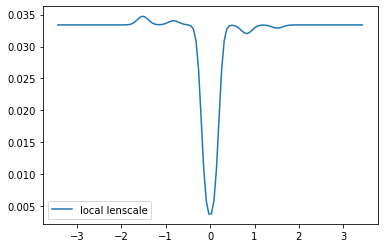

In [105]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = np.random.multivariate_normal(pred_y.reshape(-1), cov_y, 10)
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name)
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), nonstat_gp.kernel_.k2.theta_gp
             * 10**nonstat_gp.kernel_.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)

# Stationary
fit_predict_plot(gp, 'RBF')
# Stationary
fit_predict_plot(GPygp, 'RBF GPy')
# Non-Stationary

fit_predict_plot(nonstat_gp, 'LLS RBF')

## Olympic marathon data

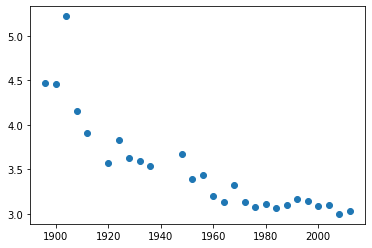

In [110]:
!pip -qq install pods
import pods
data = pods.datasets.olympic_marathon_men()
train_X = data['X']
test_X = np.linspace(data['X'].min()-10, data['X'].max()+10, 120).reshape(-1,1)
train_y = data['Y']
plt.scatter(train_X, train_y);

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = C() \
  * LocalLengthScalesKernel.construct(train_XX, l_L=0.1, l_U=2.0, l_samples=10)
nonstat_gp = GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

## Testing

RBF 2.89**2 * RBF(length_scale=0.173)
RBF GPy   rbf.         |               value  |  constraints  |  priors
  variance     |  25.399507699526374  |      +ve      |        
  lengthscale  |   4.279766247690703  |      +ve      |        
LLS RBF 2.11**2 * LocalLengthScalesKernel(theta_gp=[0.06416411], theta_l=[0.09135202], length_scales=[0.78017281 0.1239967  0.38226748 1.56445926 1.37125041 0.5319983
 1.98142023 0.77761474 1.23319618 0.298899  ])


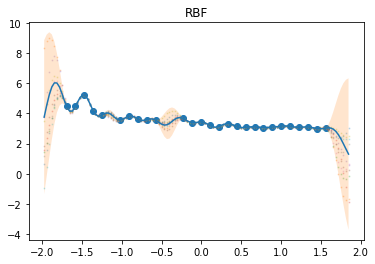

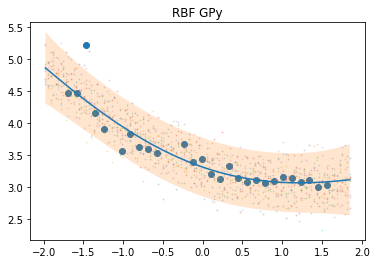

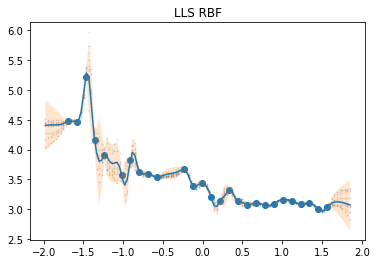

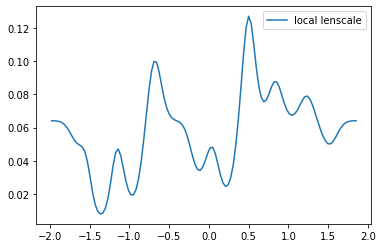

In [111]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = np.random.multivariate_normal(pred_y.reshape(-1), cov_y, 10)
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name)
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), nonstat_gp.kernel_.k2.theta_gp
             * 10**nonstat_gp.kernel_.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)

# Stationary
fit_predict_plot(gp, 'RBF')
# Stationary
fit_predict_plot(GPygp, 'RBF GPy')
# Non-Stationary

fit_predict_plot(nonstat_gp, 'LLS RBF')

# Manifold kernel (work under progress)

Works similar to the neural network kernel. We can map individual features to multiple dimentions via seperate neural net architectures.

## Defining Stationary and Non-stationary GP (gp and nonstat_gp)

In [53]:
# sklearn
kernel = C() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# GPy
class GPyGPR:
  def __init__(self, input_dim, kern):
    if kern=='rbf':
      self.GPykernel = GPyRBF(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    if kern=='m32':
      self.GPykernel = GPyMatern(input_dim=input_dim, active_dims=list(range(input_dim)), ARD=False)
    self.kernel = self.GPykernel
  def fit(self, X, y):
    self.GP = GPRegression(X, y, self.GPykernel, noise_var=10**-10)
    self.GP.optimize_restarts(10, verbose=0)
    self.kernel_ = self.GP.kern
  
  def predict(self, X, return_cov):
    y, var = self.GP.predict(X, full_cov=True)
    return y, var

GPygp = GPyGPR(1, 'rbf')

# Non stationary kernel
nonstat_kernel = C()\
                *ManifoldKernel.construct(base_kernel=RBF(), architecture=((1, 2),),
                               transfer_fct="relu", max_nn_weight=1)
# architecture is neural net architecture (input_dim, hidden1_dim, hidden2_dim, ..., output_dim)
nonstat_gp = GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0)

print("sklearn kernel=\n", kernel,sep='',end='\n\n')
print("GPy kernel=\n", GPygp.GPykernel,sep='',end='\n\n')
print("Manifold kernel=\n", nonstat_kernel,sep='')

sklearn kernel=
1**2 * RBF(length_scale=1)

GPy kernel=
  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Manifold kernel=
1**2 * ManifoldKernel(0.957, 0.642, -0.948, 0.987, 0)


## Testing on step function

RBF 1.55**2 * RBF(length_scale=0.0975)
RBF GPy   rbf.         |               value  |  constraints  |  priors
  variance     |  1.7303604955328948  |      +ve      |        
  lengthscale  |  1.7354045254195403  |      +ve      |        
Manifold RBF 1.76**2 * ManifoldKernel(0.988, 0.106, 0.323, 0.0128, -2.36)


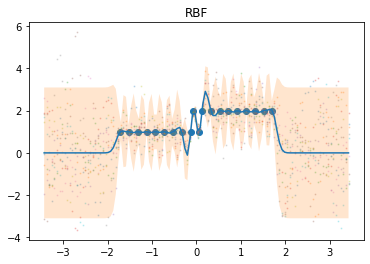

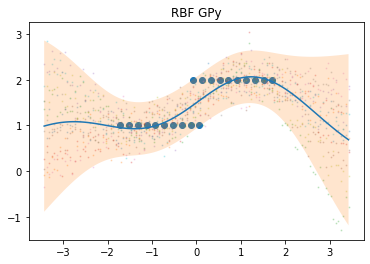

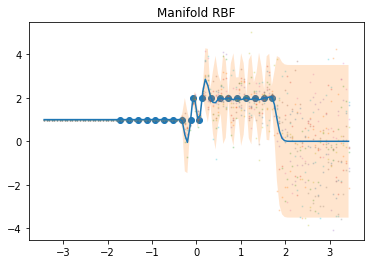

In [55]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = np.random.multivariate_normal(pred_y.reshape(-1), cov_y, 10)
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name)
  print(name, reg.kernel_)

# Stationary
fit_predict_plot(gp, 'RBF')
# Stationary
fit_predict_plot(GPygp, 'RBF GPy')
# Non-Stationary
fit_predict_plot(nonstat_gp, 'Manifold RBF')